Теперь решаем задачу регрессии - предскажем цены на недвижимость.

1. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)

В качестве решения: Jupyter notebook с кодом, комментариями и графикам

### 1. Подготовим данные 

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

In [81]:
#%config IPCompleter.greedy=True

In [82]:
df = pd.read_csv('train.csv')
df_sub = pd.read_csv('test.csv')

In [83]:
df['type'] = 'train'
df_sub['type']='submission'

In [84]:
df.shape

(1460, 82)

In [85]:
df_sub.shape

(1459, 81)

In [86]:
# объединим в один df для get_dummies
df_total = pd.concat([df, df_sub], axis=0, sort = False)

In [87]:
df_total.shape

(2919, 82)

In [88]:
num_col_tot = list([c for c in df_total.columns 
                    if df_total[c].dtype.name != 'object' and c not in ['Id','SalePrice']])

In [89]:
# отсутствующие числовые данные
df_nan = df_total[num_col_tot].isnull().sum()
df_nan[df_total[num_col_tot].isnull().sum()>1]

LotFrontage     486
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
dtype: int64

In [90]:
# заменим числовые пропуски на 0 
# а остальные пропуски в категориальных фичах на "No", т.к. они обозначают отсутствие признака - например, гаража, бассейна и.т.д
df_total[num_col_tot] = df_total[num_col_tot].fillna(0)

In [91]:
# посмотрим на категориальные признаки, их много 0_о, как и вариантов значений в них
cat_col = [c for c in df.columns if df[c].dtype.name == 'object']
df_total[cat_col] = df_total[cat_col].fillna('No')

In [92]:
df_total_dummies = pd.get_dummies(df_total[cat_col], columns=cat_col)

In [93]:
#  фичей много, данных мало. интуитивно хочется подрезать фичи, но пока оставим
df_total_dummies.shape

(2919, 276)

In [94]:
# соединим все вместе
data = pd.concat([df_total[num_col_tot], df_total_dummies], axis = 1)

In [95]:
#разделим на train и submission
data_tr = data[data['type_submission']==0]
data_sub = data[data['type_submission']==1]

In [96]:
data_tr = data_tr.drop(columns = ['type_submission','type_train'] , axis=1)
data_sub = data_sub.drop(columns = ['type_submission','type_train'] , axis=1)

In [97]:
X = data_tr
y = df.SalePrice

X_sub = data_sub

### 2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей 

In [98]:
# уберем назойливые предупреждения про устаревание
import warnings
warnings.filterwarnings("ignore")

In [99]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [100]:
clf = RandomForestRegressor()

In [101]:
# неплохо, случайный лес объясняет 84,97% дисперсии
scores = cross_val_score(clf, X, y, cv=10, scoring='r2')
scores.mean()

0.8497484122360465

### 3. Построить случайный лес, вывести важность признаков

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [70]:
clf = RandomForestRegressor()

In [103]:
clf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [104]:
# цена в большей степени зависит от общего состояния недвижимости 

feat_imp = pd.DataFrame(X.columns, columns=['feature'])
feat_imp['importance'] = clf.feature_importances_

feat_imp.sort_values(by='importance', ascending=False).head()

,feature,importance
3,OverallQual,0.584454
15,GrLivArea,0.101985
8,BsmtFinSF1,0.042569
13,2ndFlrSF,0.038624
11,TotalBsmtSF,0.027736


In [105]:
predictions = clf.predict(X_sub)

In [106]:
submussion = 'Id,SalePrice\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(df_sub.Id, predictions)])

In [107]:
with open('submission_rf.csv', 'w') as file:
    file.write(submussion)

на Kaggle RMSE 0.15 

### 4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

In [110]:
from sklearn.model_selection import train_test_split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [112]:
# для линейной понадобится нормирование
from sklearn.preprocessing import StandardScaler

In [113]:
scaler = StandardScaler()
scaler.fit(X_train[num_col_tot])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [114]:
X_train[num_col_tot] = scaler.transform(X_train[num_col_tot])
X_test[num_col_tot] = scaler.transform(X_test[num_col_tot])

In [115]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test /stack_cv.n_splits

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

In [117]:
clf_lin_reg = LinearRegression()
clf_rand_for_reg = RandomForestRegressor()
clf_svr_poly = svm.SVR(kernel='poly', degree=3)

In [118]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

# модель 1
print('Linear_Regression_features...')
meta_tr, meta_te = get_meta_features(clf_lin_reg, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('Linear_Regression_pred')

# модель 2
print('Random_Forest_Reression features...')
meta_tr, meta_te = get_meta_features(clf_rand_for_reg, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('Random_Forest_Reression_pred')

# модель 3
print('SVR_poly_3...')
meta_tr, meta_te = get_meta_features(clf_svr_poly, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('SVR_poly_3_pred')

Linear_Regression_features...
Random_Forest_Reression features...
SVR_poly_3...


In [119]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [120]:
clf_lr_meta = LinearRegression()
clf_lr_meta.fit(X_meta_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [121]:
y_pred_meta_test = clf_lr_meta.predict(X_meta_test)

In [122]:
coefs = clf_lr_meta.coef_

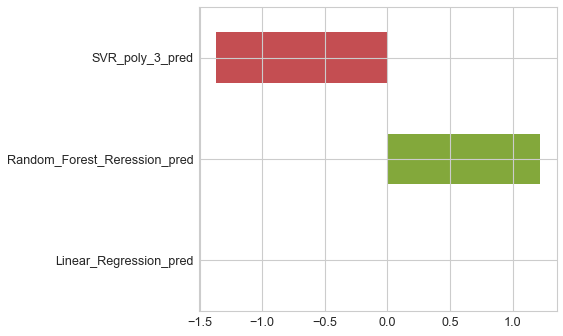

In [124]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

### проверим теперь модель на отложенной выборке

In [126]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

# модель 1
print('Linear_Regression_features...')
meta_tr, meta_te = get_meta_features(clf_lin_reg, X_train, y_train, X_sub, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('Linear_Regression_pred')

# модель 2
print('Random_Forest_Reression features...')
meta_tr, meta_te = get_meta_features(clf_rand_for_reg, X_train, y_train, X_sub, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('Random_Forest_Reression_pred')

# модель 3
print('SVR_poly_3...')
meta_tr, meta_te = get_meta_features(clf_svr_poly, X_train, y_train, X_sub, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('SVR_poly_3_pred')

Linear_Regression_features...


ValueError: operands could not be broadcast together with shapes (438,) (1459,) (438,) 

In [136]:
print('Linear_Regression_features...')
meta_tr, meta_te = get_meta_features(clf_lin_reg, X_train, y_train, X_test, stack_cv)

Linear_Regression_features...


In [137]:
print('Linear_Regression_features...')
meta_tr, meta_te = get_meta_features(clf_lin_reg, X_train, y_train, X_sub, stack_cv)

Linear_Regression_features...


ValueError: operands could not be broadcast together with shapes (438,) (1459,) (438,) 